![title](hyperspectral_analysis_paper.png)

In [1]:
%matplotlib inline
import mpld3
mpld3.enable_notebook()
from spectral_cube import SpectralCube
import pickle
import rasterio
import spectral
import matplotlib.pyplot as plt
from skimage.restoration import denoise_tv_chambolle
import numpy as np
import cv2
from rasterio.plot import reshape_as_image
import os
from spectral.algorithms import mnf
from spectral import principal_components
import pysptools

### Load IIRS Hyperspectral Data from QUBE

In [2]:
hype_file = r'./landingzone_ref/iirs/data/calibrated/20210622/ch2_iir_nci_20210622T1256344234_d_img_d32.hdr'
tiffile = r'./final_input/finaliirs01.tif'
rasterdat = rasterio.open(tiffile, "r+")
img = rasterdat.read()
img = reshape_as_image(img)
img = img[400:730, :, :]

### L1 Norm Based Denoising Algorithm

(330, 244, 256)
(330, 244, 256)


ImageView object:
  Display bands       :  [0]
  Interpolation       :  <default>
  RGB data limits     :
    R: [-29.75505256652832, 1060.3475341796875]
    G: [-29.75505256652832, 1060.3475341796875]
    B: [-29.75505256652832, 1060.3475341796875]

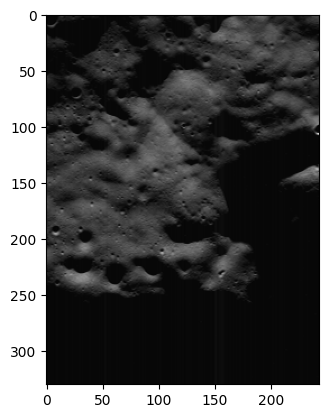

In [80]:
denoised_data = np.empty_like(img)
weight = 0.1

for i in range(img.shape[0]):
    denoised_data[i] = denoise_tv_chambolle(img[i], weight=weight)

# denoised_data = denoised_data.transpose((0,1,2))[:, :, 33:79]
denoised_data = denoised_data.transpose((0,1,2))
print(img.shape)
print(denoised_data.shape)
spectral.imshow(denoised_data[:, :, 45])

### Maximum Noise Fraction (MNF) Dimensionality Reduction

In [3]:
import numpy as np
from numpy.linalg import inv, eigh

data = img.copy()
# Assuming `data` is your hyperspectral data array with shape (lines, samples, bands)
lines, samples, bands = data.shape

# Reshape data to 2D array of shape (lines * samples, bands)
data_reshaped = data.reshape((lines * samples, bands))

# Step 1: Estimate the noise covariance matrix
# This can be done using a simple method like differencing adjacent pixels
diffs = data_reshaped[1:, :] - data_reshaped[:-1, :]
noise_cov = np.cov(diffs, rowvar=False)

# Step 2: Compute the inverse of the noise covariance matrix
noise_cov_inv = inv(noise_cov)

# Step 3: Perform noise whitening
mean_centered_data = data_reshaped - np.mean(data_reshaped, axis=0)
whitened_data = np.dot(mean_centered_data, np.linalg.cholesky(noise_cov_inv).T)

# Step 4: Apply PCA to the whitened data
cov_matrix = np.cov(whitened_data, rowvar=False)
eigenvalues, eigenvectors = eigh(cov_matrix)

# Sort eigenvalues and eigenvectors in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]

# Transform the data using the sorted eigenvectors
mnf_transformed_data = np.dot(whitened_data, sorted_eigenvectors)

# Reshape MNF transformed data back to original shape with reduced bands
mnf_transformed_data = mnf_transformed_data.reshape((lines, samples, bands))
mnf_transformed_data = mnf_transformed_data[:, :, :10]

ImageView object:
  Display bands       :  [0, 1, 2]
  Interpolation       :  <default>
  RGB data limits     :
    R: [-201.5746140223841, 773.377369107641]
    G: [-38.86877941665445, 1171.8502009164586]
    B: [-52.34703594829066, 125.09763142099663]

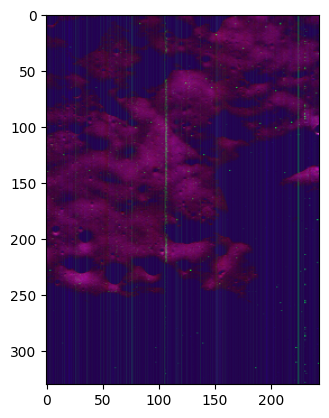

In [30]:
import spectral

spectral.imshow(mnf_transformed_data, bands=[0,1,2])

In [6]:
# print(mnf_transformed_data.shape)

(779, 240, 256)


### N-FINDR END MEMBER EXTRACTION

In [7]:
# from pysptools.eea import NFINDR

# mnf_data = mnf_transformed_data.copy()
# lines, samples, bands = mnf_data.shape
# # mnf_reshaped = mnf_data.reshape((lines * samples, bands))

# # Apply the N-FINDR algorithm to find the endmembers
# num_endmembers = 5  # Specify the number of endmembers you want to extract
# nfindr = NFINDR()
# endmembers = nfindr.extract(mnf_data, num_endmembers)


In [8]:
# print(endmembers.shape)

(5, 256)


### Pixel Purity Index (PPI)

In [9]:
num_iterations = 1000  # Number of iterations for PPI
threshold = 0.1  # Threshold for pixel purity

# ppi = spectral.ppi(denoised_data, num_iterations, threshold)
ppi = spectral.ppi(mnf_transformed_data, num_iterations, threshold)

Running 1000 pixel purity iterations...  0.0Running 1000 pixel purity iterations...  1.0Running 1000 pixel purity iterations...  2.0Running 1000 pixel purity iterations...  3.0Running 1000 pixel purity iterations...  4.0Running 1000 pixel purity iterations...  5.0Running 1000 pixel purity iterations...  6.0Running 1000 pixel purity iterations...  7.0Running 1000 pixel purity iterations...  8.0Running 1000 pixel purity iterations...  9.0Running 1000 pixel purity iterations... 10.0Running 1000 pixel purity iterations... 11.0Running 1000 pixel purity iterations... 12.0Running 1000 pixel purity iterations... 13.0Running 1000 pixel purity iterations... 14.0Running 1000 pixel purity iterations... 15.0Running 1000 pixel purity iterations... 16.0Running 1000 pixel purity iterations... 17.0Running 1000 pixel purity iterations... 18.0Running 1000 pixel purity iterations... 19.0Running 1000 pixel purity iterations... 20.0Running 1000 pixel purity iterations... 21.0Running 1000 pixel purity iterat

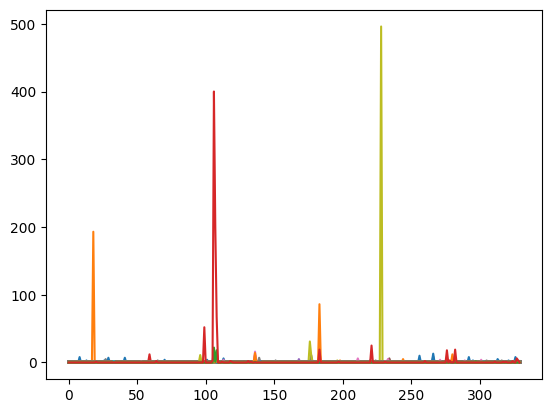

In [10]:
plt.plot(ppi)
plt.show()

### K_Means Endmember Extraction

In [11]:
from sklearn.cluster import KMeans

# Apply K-Means clustering to the PPI result to find endmembers
n_clusters = 7  # Number of endmembers to identify
ppi_flat = ppi.reshape((-1, ppi.shape[-1]))  # Flatten the PPI result for clustering
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
kmeans.fit(ppi_flat)

# Extract the cluster centers (endmember spectra)
endmember_indices = np.argmin(kmeans.transform(ppi_flat), axis=0)
# endmember_spectra = denoised_data.reshape((-1, denoised_data.shape[-1]))[endmember_indices]
endmember_spectra = mnf_transformed_data.reshape((-1, mnf_transformed_data.shape[-1]))[endmember_indices]

C:\Users\mainak\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [64]:
print(endmember_indices)

[  0 732 189 512 580 518 594]


### SAM / MSAM (Spectral Angle Mapper - Modified)

In [12]:
# data = denoised_data.copy()
data = mnf_transformed_data.copy()
data_reshaped = data.reshape((-1, data.shape[-1]))
print(endmember_spectra.shape)
# sam_result = spectral.msam(denoised_data, endmember_spectra)
# sam_result = spectral.msam(mnf_transformed_data, endmember_spectra)
sam_result = spectral.msam(mnf_transformed_data, endmember_spectra)

(7, 10)


In [10]:
from scipy.spatial import ConvexHull

def continuum_removal_on_bands(spectrum, band_indices):
    """
    Perform continuum removal on specified bands of a single spectrum.
    
    Parameters:
    spectrum (1D numpy array): The spectrum to process.
    band_indices (list of int): The indices of the bands to apply continuum removal.
    
    Returns:
    continuum_removed_spectrum (1D numpy array): The spectrum with continuum removed on specified bands.
    """
    selected_spectrum = spectrum[band_indices]
    points = np.vstack((band_indices, selected_spectrum)).T
    hull = ConvexHull(points)
    continuum = np.interp(band_indices, hull.vertices, selected_spectrum[hull.vertices])
    continuum_removed = selected_spectrum / continuum
    continuum_removed_spectrum = spectrum.copy()
    continuum_removed_spectrum[band_indices] = continuum_removed
    return continuum_removed_spectrum

def apply_continuum_removal_on_cube(cube, band_indices):
    """
    Apply continuum removal to specified bands in a hyperspectral cube.
    
    Parameters:
    cube (3D numpy array): The hyperspectral data cube with shape (rows, cols, bands).
    band_indices (list of int): The indices of the bands to apply continuum removal.
    
    Returns:
    continuum_removed_cube (3D numpy array): The hyperspectral cube with continuum removed on specified bands.
    """
    rows, cols, bands = cube.shape
    continuum_removed_cube = cube.copy()

    for i in range(rows):
        for j in range(cols):
            spectrum = cube[i, j, :]
            continuum_removed_spectrum = continuum_removal_on_bands(spectrum, band_indices)
            continuum_removed_cube[i, j, :] = continuum_removed_spectrum

    return continuum_removed_cube

# Assuming `cube` is your hyperspectral data cube with shape (rows, cols, bands)
# Specify the band indices for which to remove the continuum
band_indices = [0, 1, 2, 3, 4, 5, 6] 

# Apply continuum removal on the specified bands
continuum_removed_cube = apply_continuum_removal_on_cube(sam_result, band_indices)


### Plotting End-member Spectra derived from Image

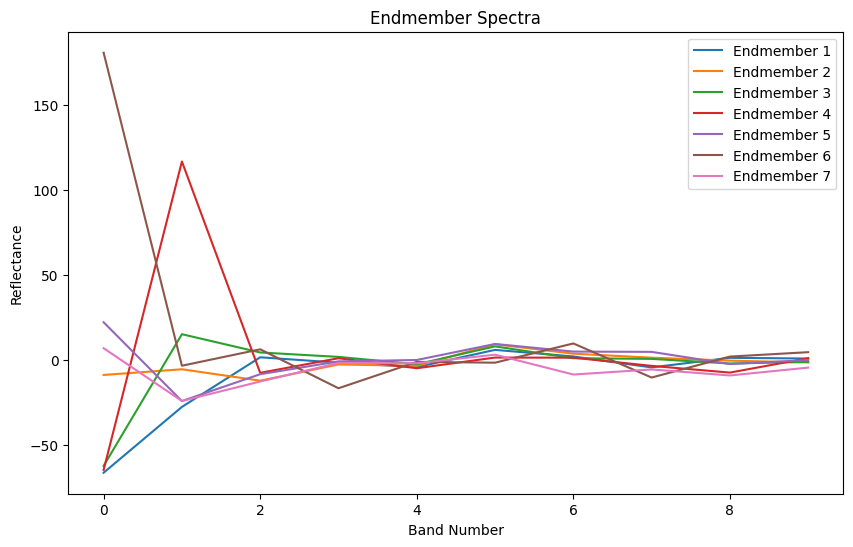

In [13]:
num_endmembers, num_bands = endmember_spectra.shape

# Plot each endmember spectrum
plt.figure(figsize=(10, 6))
for i in range(num_endmembers):
    plt.plot(range(num_bands), endmember_spectra[i], label=f'Endmember {i+1}')

# Add labels and legend
plt.xlabel('Band Number')
plt.ylabel('Reflectance')
plt.title('Endmember Spectra')
plt.legend()
plt.show()

(330, 244, 7)


ImageView object:
  Display bands       :  [0, 1, 2]
  Interpolation       :  <default>
  RGB data limits     :
    R: [-0.9383988649187354, 0.9999999865842415]
    G: [-0.462467600137316, 1.0]
    B: [-0.9629775269077836, 1.0]

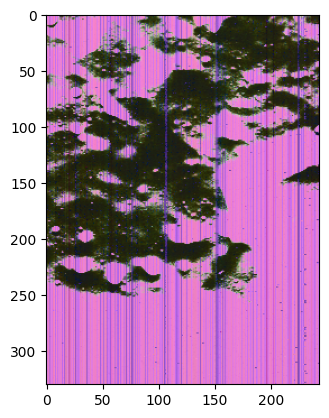

In [76]:
print(sam_result.shape)
spectral.imshow(sam_result, bands=[0,1,2])

ImageView object:
  Display bands       :  [0, 1, 2]
  Interpolation       :  <default>
  RGB data limits     :
    R: [-0.8978491957933283, 0.9505170506834555]
    G: [-0.42960837955662806, 0.6626713222201566]
    B: [-0.9567447416657603, 0.9304691038972058]

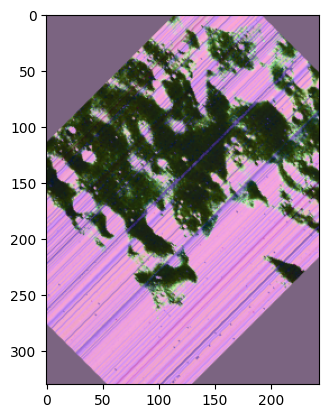

In [83]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

newimg = rotate_image(sam_result[:, :, :3], -45)
spectral.imshow(newimg)


In [53]:
# from matplotlib.colors import ListedColormap

# # Define a colormap with a distinct color for each endmember
# colors = [
#     [1, 0, 0],   # Red
#     [0, 1, 0],   # Green
#     [0, 0, 1],   # Blue
#     [1, 1, 0],   # Yellow
#     [1, 0, 1],   # Magenta
#     [0, 1, 1],   # Cyan
#     [0.5, 0.5, 0.5] # Gray (for additional endmembers if any)
# ]
# cmap = ListedColormap(colors[:num_endmembers])

# # Display the classification result as a false color composite
# plt.imshow(sam_result[:, :, 2:5], cmap=cmap)
# plt.colorbar(ticks=range(num_endmembers), label='Endmember Index')
# plt.title('False Color Composite of Endmember Spectra')
# plt.show()

### Band Shape Algorithms

In [26]:
def calculate_band_strength(spectrum, band_center=11, band_width=16):
    start = band_center - band_width // 2
    end = band_center + band_width // 2
    continuum = np.linspace(spectrum[start], spectrum[end], end - start + 1)
    band_strength = continuum - spectrum[start:end+1]
    return band_strength.mean()


def calculate_band_curvature(spectrum, band_center=8, band_width=10):
    start = band_center - band_width // 2
    end = band_center + band_width // 2
    x = np.arange(start, end + 1)
    y = spectrum[start:end + 1]
    coefficients = np.polyfit(x, y, 2)  # Fit a 2nd-degree polynomial
    curvature = coefficients[0]
    return curvature

def calculate_band_tilt(spectrum, start_band=13, end_band=19):
    start_reflectance = spectrum[start_band]
    end_reflectance = spectrum[end_band]
    band_tilt = (end_reflectance - start_reflectance) / (end_band - start_band)
    return band_tilt

band_center = 4  # Index of the band center
band_width = 9 
start_band = 0  # Starting band index
end_band = 9

rows, cols, bands = denoised_data.shape

band_strength_image = np.zeros((rows, cols))
band_curvature_image = np.zeros((rows, cols))
band_tilt_image = np.zeros((rows, cols))

for r in range(rows):
    for c in range(cols):
        # pixel_spectrum = denoised_data[r, c, :]
        pixel_spectrum = mnf_transformed_data[r, c, :]
        band_strength_image[r, c] = calculate_band_strength(pixel_spectrum, band_center, band_width)
        # band_strength_image[r, c] = calculate_band_strength(pixel_spectrum)
        band_curvature_image[r, c] = calculate_band_curvature(pixel_spectrum, band_center, band_width)
        # band_curvature_image[r, c] = calculate_band_curvature(pixel_spectrum)
        band_tilt_image[r, c] = calculate_band_tilt(pixel_spectrum, start_band, end_band)
        # band_tilt_image[r, c] = calculate_band_tilt(pixel_spectrum)


In [26]:
print(mnf_transformed_data.shape)

(779, 240, 256)


ImageView object:
  Display bands       :  [0, 1, 2]
  Interpolation       :  <default>
  RGB data limits     :
    R: [-26.92263358488727, 35.08893563045456]
    G: [-12.201396589374172, 37.60786384582519]
    B: [-29.00671670278229, 35.37033493041992]

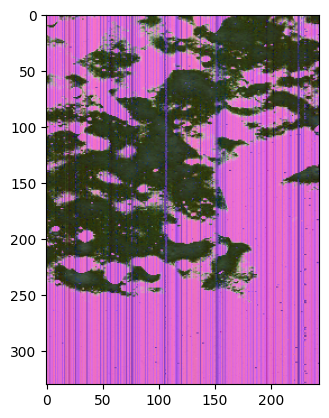

In [79]:
composite = cv2.addWeighted(sam_result[:, :, :3], 35.0, img[:, :, 50:53].astype(np.float64), 0.03, 0.0, 0.0)
spectral.imshow(composite)